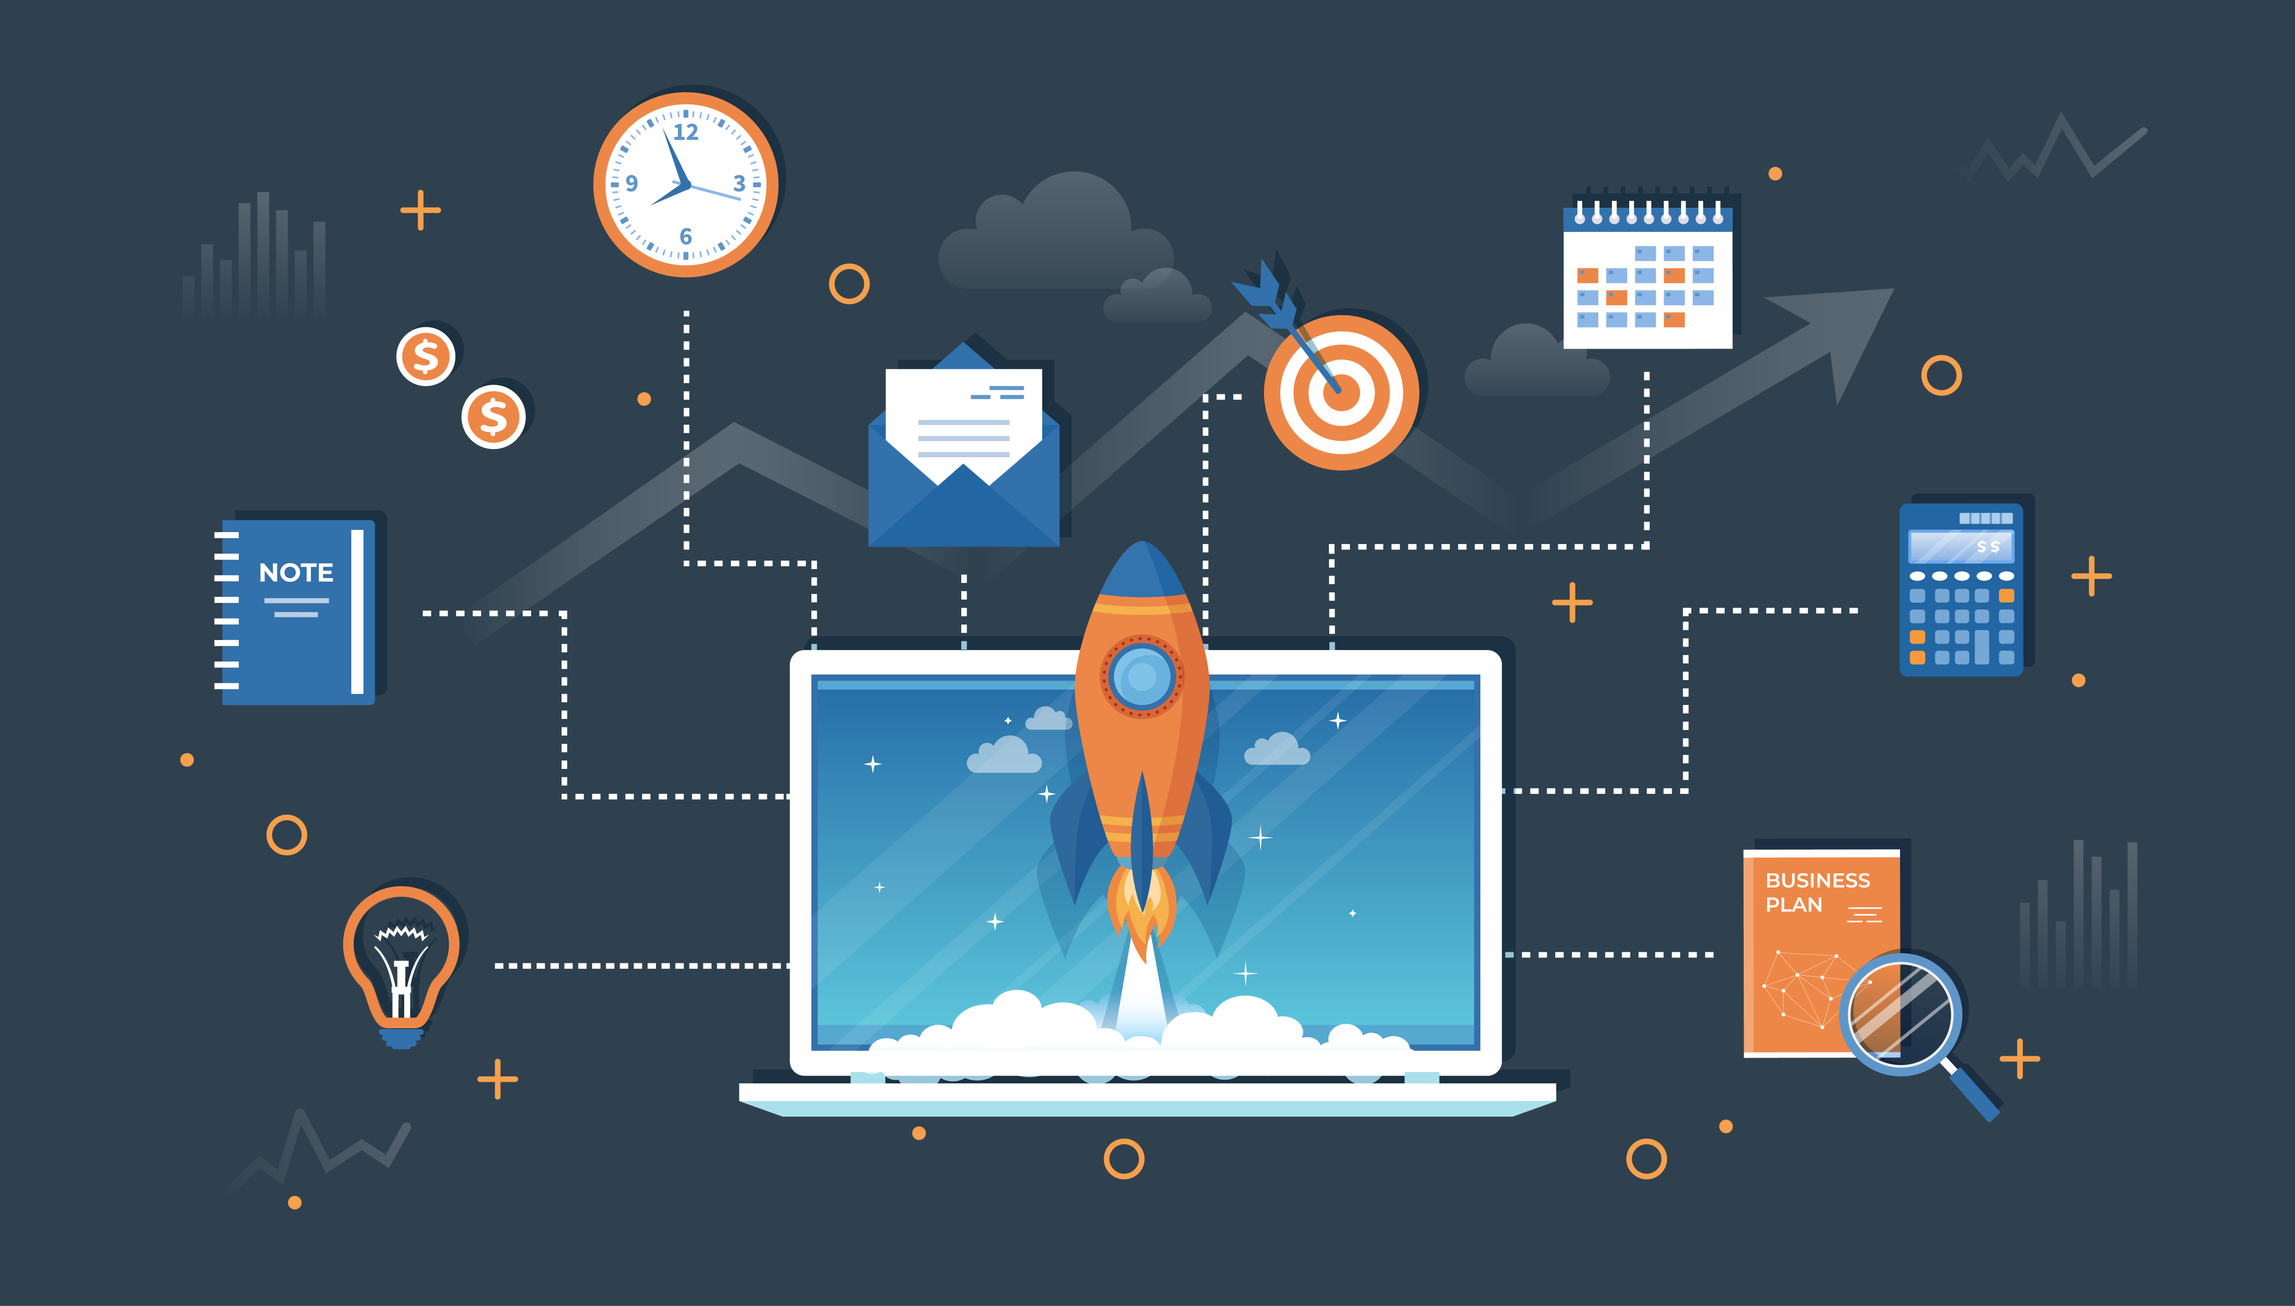

<h1><center>🇵🇰 Pakistani Startups 🇵🇰</center></h1>

# <span style="color:darkgreen;font-family:georgia;">1. Introduction</span> 

I've recently gotten more interested in startup ecosystems around the world. Obviously, the U.S. has some big names, but as technology provides opportunity to more and more people I've been excited to see what kind of advancements will come from other continents. 

So, when I found this dataset I jumped on it. I hope this notebook can help give some insight into the startup infrastructure inside Pakistan. 

### Libraries 📚

In [ ]:
import os
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
from tqdm import tqdm_notebook #gives a progress bar
import seaborn as sns

# Maps
import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim

# Matplot
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('seaborn-whitegrid')
import matplotlib.image as mpimg

# NLP/WordCloud
import nltk
from collections import Counter
import regex as re
from wordcloud import WordCloud

#Images
from PIL import Image

# Additional Libraries
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore")
from scipy import stats

# Load data
data = pd.read_csv('../input/pakistan-startup-census/Pakistan Startup Census.csv');

# <span style="color:darkgreen;font-family:georgia;">2. Data</span>

In [ ]:
print(data.shape)
data.head()

In [ ]:
data.info()

## Clean the Data 🧽

#### Here are some areas where we can make the data easier to work with:
>* The last 150 rows or so are empty
>* The data types need to be changed
>* The location and timeline data needs to be cleaned


**First, drop all rows where there is no data** ⬇

In [ ]:
data = data.dropna(how='all')
print(data.shape)

**Next,convert data types to strings** 🧵

In [ ]:
data[['Name','Location','Tagline','Category','Website','Founded','Description']] = data[['Name','Location','Tagline','Category','Website','Founded','Description']].astype('string')
print(data.dtypes)

### 2.1 DateTime Data

Make `Founded` column readable 👓

In [ ]:
# this will isolate only the year, which is all we want
data[['Founded','Month','Year']] = data.Founded.str.split(" ", n=2,expand=True)
data = data[~data.Founded.str.contains("-")]

data.loc[data['Year'].isnull(),'Year'] = data['Founded']

data = data.drop(['Founded','Month'], axis=1)
data = data.rename(columns={'Year':'Founded'})
# strip empty spaces
data['Founded'] = data.Founded.str.strip()
data = data[data['Founded'].astype(bool)].reset_index()
data = data.drop('index', axis=1)

data['Founded'] = data['Founded'].astype('int')

### 2.2 Location Data

<blockquote>We are going to be dealing mainly with startups that are located in Pakistan. So we can drop most of the locations outside of the country.</blockquote>

In [ ]:
# create new dataset that drops any location not in Pakistan
a = ["States",'Raleigh', 'York','USA','Canada','England', 'California', 'Los','South','Amsterdam']
pak = data[~data.Location.str.contains('|'.join(a))]

# Make location data only city names
city = set(['Karachi', 'Lahore', 'Islamabad','Faisalabad','Rawalpindi',
        'Peshawar','Gujrat','Sialkot','Hyderabad','Multan','Sargodha',
        'Faisalabad','Quetta','Wah','Gujranwala','Pakhtunkhwa'
       ])


pak['City'] = pak.Location.str.extract('({0})'.format('|'.join(city)))

**<span style="font-size:16px;">Coordinates: 🌐</span>**

Add `latitude` and `longitude` to the dataset for each city
***

In [ ]:
geolocator = Nominatim(user_agent="example")

lat = []
lon = []
for j in pak['City']:
    try:
        loc = geolocator.geocode(j).raw
        lat.append(loc['lat'])
        lon.append(loc['lon'])
    except:
        lat.append(np.nan)
        lon.append(np.nan)  
        
# convert to series and add as column in dataset
la = pd.Series(lat)
lo = pd.Series(lon)

pak['Lat'] = la.values
pak['Lon'] = lo.values

pak[['Lat','Lon']] = pak[['Lat','Lon']].astype(float)

<blockquote>Then we're gonna add in some noise to the Latitude and Longitude columns because we don't want all of the locations to be right on top of each other.


<div class="alert alert-block alert-info"><b>Note:</b> This means the location data is not meant to be accurate at the street level. Just the city level.</div></blockquote>

In [ ]:
#add some noise to each item in the series because they won't all be at the exact same GPS
pak['Lat'] = pak['Lat'].apply(lambda x: x + np.random.rand()/10.0)
pak['Lon'] = pak['Lon'].apply(lambda x: x + np.random.rand()/10.0)

print(pak.shape)
pak.head()

# <span style="color:darkgreen;font-family:georgia;">3. Timeline</span>

<b><span style="font-size:16px;">To Do:</span></b>

>We want to determine the number of companies founded in each year. We will only be including companies founded after 1999.  

In [ ]:
startup_dist = data.loc[data['Founded'] >1999]

plt.subplots(figsize=(18,10))
startup_dist.Founded.value_counts().plot(kind='bar', color='green')
plt.xlabel("Year", fontsize=14)
plt.ylabel("# of Startups", fontsize=14)
plt.title("Pakistani Startup Distribution", fontsize=20);

# <span style="color:darkgreen;font-family:georgia;">4. Location</span>

### 4.1 Map

In [ ]:
# Pakistan Map
Pakistan = folium.Map(location=[30.5,69.5], tiles='cartodbpositron',
                      min_zoom=3.5, max_zoom=12, zoom_start=5)

In [ ]:
mc = MarkerCluster()

for i in range(0,len(pak)):
    mc.add_child(folium.Marker([pak.iloc[i]['Lat'], pak.iloc[i]['Lon']],
                               tooltip = '<li><bold>City: ' +str(pak.iloc[i]['City'])+
                                '<li><bold>Company: ' +str(pak.iloc[i]['Name'])+ 
                                '<li><bold>Website: ' +str(pak.iloc[i]['Website'])+ 
                                '<li><bold> Founded: ' +str(pak.iloc[i]['Founded']))
                              )
    
Pakistan.add_child(mc)

Pakistan

It looks like the most popular cities for startups are:
>1. Karachi
>2. Lahore
>3. Islamabad

### 4.2  Startup City Distribution

In [ ]:
x = pak.City.value_counts(normalize=True).round(3).tolist()


plt.style.use('fivethirtyeight')
plt.subplots(figsize=(14,7))
pak.City.value_counts(normalize=True).plot(kind='barh',color='green')
for i, v in enumerate(x):
    plt.text(v+.0025, i, str(v*100)+'%', fontweight='bold',
            Bbox = dict(facecolor = 'green', alpha =.2))
plt.xlabel("City", fontsize=14)
plt.ylabel("Distribution of Startups", fontsize=14)
plt.title("Pakistani Startup Distribution", fontsize=20);

### 4.3 City Distribution By Year

### Put Pakistani Flag in Background of all Barcharts

📌 **Note:** No startups inside Pakistan in 2001.


In [ ]:
pak_g = pak.loc[pak['Founded'] >1999]

Import image for bar chart background

In [ ]:
img = plt.imread('../input/pakistan-photo/pak_photo.jpeg')

In [ ]:
pak_2000s = pak_g.loc[pak_g['Founded'] <2006]

plt.style.use('default')
plt.figure(figsize=(16, 8))
ax = sns.countplot(pak_2000s['City'], palette='hls')

plt.imshow(img, aspect='auto', alpha=155, extent=[-1,3,0,4.1])

plt.xlabel('', fontsize=5)
plt.ylabel("# of Startups", fontsize=12)
plt.title("2000-2005", fontsize=20);

In [ ]:
pak_2000ss = pak_g.loc[(pak_g['Founded']>2005) & (pak_g['Founded'] < 2011)]

plt.figure(figsize=(18,10))
ax = sns.countplot(pak_2000ss['City'], palette='rocket')
plt.xlabel('', fontsize=14)
plt.ylabel("# of Startups", fontsize=14)
plt.title("2006-2010", fontsize=20)
plt.imshow(img, aspect='auto', alpha=155, extent=[-1, 6, 0, 6.2]);

In [ ]:
pak_2011 = pak_g.loc[pak_g['Founded']==2011]

plt.figure(figsize=(18,10))
ax = sns.countplot(pak_2011['City'], palette='hls')
plt.xlabel('', fontsize=14)
plt.ylabel("# of Startups", fontsize=14)
plt.title("2011", fontsize=20)
plt.imshow(img, aspect='auto', alpha=155, extent=[-1, 3, 0, 3.2]);

In [ ]:
pak_2012 = pak_g.loc[pak_g['Founded']==2012]

plt.figure(figsize=(18, 10))
ax = sns.countplot(pak_2012['City'], palette='rocket')
plt.xlabel('', fontsize=14)
plt.ylabel("# of Startups", fontsize=14)
plt.title("2012", fontsize=20)
plt.imshow(img, aspect='auto', alpha=155, extent=[-1, 4, 0, 4.2]);

In [ ]:
pak_2013 = pak_g.loc[pak_g['Founded']==2013]

plt.figure(figsize=(18, 10))
ax = sns.countplot(pak_2013['City'], palette='hls')
plt.xlabel('', fontsize=14)
plt.ylabel("# of Startups", fontsize=14)
plt.title("2013", fontsize=20)
plt.imshow(img, aspect='auto', alpha=155, extent=[-1, 3, 0, 6.2]);

In [ ]:
pak_2014 = pak_g.loc[pak_g['Founded']==2014]

plt.figure(figsize=(18, 10))
ax = sns.countplot(pak_2014['City'], palette='hls')
plt.xlabel('', fontsize=14)
plt.ylabel("# of Startups", fontsize=14)
plt.title("2014", fontsize=20)
plt.imshow(img, aspect='auto', alpha=155, extent=[-1, 8, 0, 20]);

In [ ]:
pak_2015 = pak_g.loc[pak_g['Founded']==2015]

plt.figure(figsize=(18, 12))
ax = sns.countplot(pak_2015['City'], palette='rocket_r')
plt.xlabel('', fontsize=14)
plt.ylabel("# of Startups", fontsize=14)
plt.title("2015", fontsize=20)
plt.imshow(img, aspect='auto', alpha=155, extent=[-1, 7, 0, 45]);

In [ ]:
pak_2016 = pak_g.loc[pak_g['Founded']==2016]

plt.figure(figsize=(18,12))
ax = sns.countplot(pak_2016['City'], palette='Spectral')
plt.xlabel('', fontsize=14)
plt.ylabel("# of Startups", fontsize=14)
plt.title("2016", fontsize=20)
plt.imshow(img, aspect='auto', alpha=155, extent=[-1, 9, 0, 53]);

In [ ]:
pak_2017 = pak_g.loc[pak_g['Founded']==2017]

plt.figure(figsize=(18,12))
ax = sns.countplot(pak_2017['City'], palette='hls')
plt.xlabel('', fontsize=14)
plt.ylabel("# of Startups", fontsize=14)
plt.title("2017", fontsize=20)
plt.imshow(img, aspect='auto', alpha=155, extent=[-1, 8, 0, 20]);

In [ ]:
pak_2018 = pak_g.loc[pak_g['Founded']==2018]

plt.figure(figsize=(18,12))
ax = sns.countplot(pak_2018['City'], palette='hls')
plt.xlabel('', fontsize=14)
plt.ylabel("# of Startups", fontsize=14)
plt.title("2018", fontsize=20)
plt.imshow(img, aspect='auto', alpha=155, extent=[-1, 4, 0, 4.2]);

# <span style="color:darkgreen;font-family:georgia;">5. Word Cloud</span>

### 5.1 Industry 

In [ ]:
cat_low = data['Category'].str.cat(sep=' ')
    
cat = re.sub("\s*-\s*", "", cat_low)
cat_words = re.sub('&',' ', cat)

cat_tokens = re.findall('\S+', cat_words)
for word in cat_tokens:
    if len(word) < 3:
        cat_tokens.remove(word)
        
#remove stop words
stop_words = nltk.corpus.stopwords.words('english')

best_cat = []
for word in cat_tokens:
    if word not in stop_words:
        best_cat.append(word)

In [ ]:
def i_wc(data,bgcolor,title):
    plt.figure(figsize = (60,60))
    wc = WordCloud(background_color = bgcolor, max_words = 200, max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc.recolor(colormap= 'terrain'))
    plt.axis('off')

i_wc(best_cat,'black','Common Words' )

### 5.2 Tagline

In [ ]:
tag_low = data['Tagline'].str.lower().str.cat(sep=' ')
    
tag_words = re.sub('[^A-Za-z]+', ' ', tag_low)

tag_tokens = re.findall('\w+', tag_words)
for word in tag_tokens:
    if len(word) < 2:
        tag_tokens.remove(word)


#remove stop words
stop_words = nltk.corpus.stopwords.words('english')

best_tag = []
for word in tag_tokens:
    if word not in stop_words:
        best_tag.append(word)

In [ ]:
def t_wc(data,bgcolor,title):
    plt.figure(figsize = (80,80))
    wc = WordCloud(background_color = bgcolor, max_words = 1000, max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc.recolor(colormap= 'terrain'))
    plt.axis('off')

t_wc(best_tag,'black','Common Words' )

### 5.3 Description

In [ ]:
des_low = data['Description'].str.lower().str.cat(sep=' ')
    
des_words = re.sub('[^A-Za-z]+', ' ', des_low)

des_tokens = re.findall('\w+', des_words)
for word in des_tokens:
    if len(word) < 2:
        des_tokens.remove(word)


#remove stop words
stop_words = nltk.corpus.stopwords.words('english')

best_des = []
for word in des_tokens:
    if word not in stop_words:
        best_des.append(word)

🚩 **Import image for WordCloud mask** ✈️

In [ ]:
pak_mask = np.array(Image.open('../input/pakistan-img/pak_flag.png'))

In [ ]:
def d_wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 20000, mask=pak_mask, max_font_size = 120)
    wc.generate(' '.join(data))
    plt.imshow(wc.recolor(colormap= 'Dark2_r'))
    plt.axis('off')
    plt.title(title, fontsize=18)

d_wc(best_des,'white','Most Common Startup Descriptions' )

## Conclusion

Looks like most of the startups in Pakistan are concentrated in three cities, with a few others dispersed througout the country. It makes sense that most of the startups would be in Karachi and Lahore, the two largest cities in Pakistan, and that Islamabad, the capital, would house the third most. These cities likely have more people, resources, and opportunity. 

Additionally, we can see that most of the startups are tech related and that the number of startups in the country really started to take off in the 2010s. 

Hopefully, this industry will continue to grow and these companies will be able to contributions that impact Pakistan and the world. 